In [1]:
# Imports
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model & reflect the tables
base = automap_base()
base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Design a query to retrieve the last 12 months of precipitation data and plot the results


In [9]:
first_date = session.query(Measurement.date).\
                order_by(Measurement.date.asc()).\
                first()
first_date

('2010-01-01')

In [10]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).\
                order_by(Measurement.date.desc()).\
                first()
last_date

('2017-08-23')

In [11]:
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        filter(func.strftime("%Y-%m-%d", Measurement.date)>= '2016-08-23').\
        order_by(func.count(Measurement.station).\
        desc())
station_most_active = [m for m in most_active[0]]
station_most_active[0]

'USC00519397'

In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
                filter(func.strftime("%Y-%m-%d", Measurement.date)>= '2016-08-23').\
                all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.DataFrame(prcp, columns=['Date','Precipitation'])
prcp = prcp.dropna(how='any')
prcp = prcp.reset_index(drop=True)
prcp = prcp.set_index('Date', inplace=False)

In [14]:
# Sort the dataframe by date
prcp = prcp.sort_index()

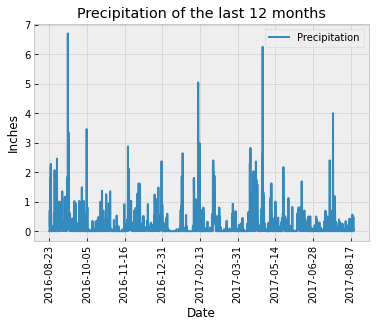

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp.plot(rot=90)
plt.title('Precipitation of the last 12 months')
plt.ylabel('Inches')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(prcp.describe(),2)

,Precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [17]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.id).count()
count_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)? List in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc())

active_pd = pd.DataFrame(active_stations, columns=('Stations','Data Points'))
active_pd = active_pd.set_index('Stations', inplace=False)
active_pd

,Data Points
Stations,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


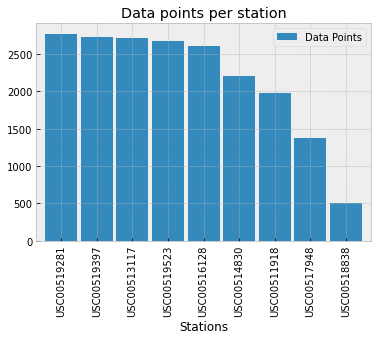

In [19]:
active_pd.plot(kind='bar',width=.9)
plt.title('Data points per station')
plt.show()

In [20]:
# Choose the station with the highest number of temperature observations.
for active in active_stations[:1]:
    most_station = active[0]
most_station

'USC00519281'

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              filter(Measurement.station == most_station)

for active in most_active:
    print(f'Information on station {most_station}: \n - Lowest temperature: {active[0]} \n - Highest temperature: {active[1]} \n - Average temperature: {round(active[2],2)}')

Information on station USC00519281: 
 - Lowest temperature: 54.0 
 - Highest temperature: 85.0 
 - Average temperature: 71.66


In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
toptemp_station = session.query(Measurement.date, Measurement.tobs).\
                filter(func.strftime("%Y-%m-%d", Measurement.date)>= '2016-08-23').\
                filter(Measurement.station == most_station).\
                all()
toptemp_station = pd.DataFrame(toptemp_station, columns=['Date','Temperature'])
toptemp_station = toptemp_station.dropna(how='any')
toptemp_station = toptemp_station.reset_index(drop=True)
toptemp_station = toptemp_station.set_index('Date', inplace=False)
toptemp_station = toptemp_station.sort_index()

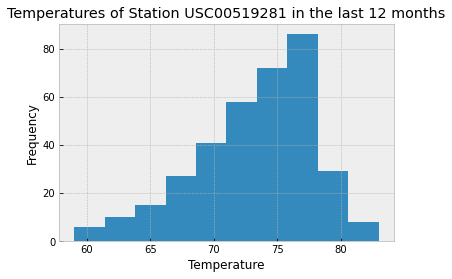

In [23]:
toptemp_station.plot(kind='hist',legend=False)
plt.title(f'Temperatures of Station {most_station} in the last 12 months')
plt.xlabel('Temperature')
plt.show()

## More data exploration

In [24]:
# Function to return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()
    return temps

In [25]:
# Select two dates to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
start_date = '2017-06-06'
end_date = '2017-06-19'
vac_data = calc_temps(start_date,end_date)
print(f'Information from {start_date} to {end_date}: \n - Lowest temperature: {vac_data[0][0]} \n - Highest temperature: {vac_data[0][1]} \n - Average temperature: {round(vac_data[0][2],2)}')

Information from 2017-06-06 to 2017-06-19: 
 - Lowest temperature: 72.0 
 - Highest temperature: 83.0 
 - Average temperature: 77.1


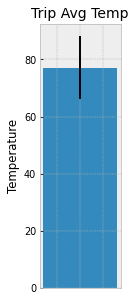

In [26]:
# Plot the results from your previous query as a bar chart. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(1.5, 5), dpi=70)
plt.bar(0,vac_data[0][2],yerr=(vac_data[0][0]-vac_data[0][1]))
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
ly_start_date = '2016-06-06'
ly_end_date = '2016-06-19'

vac_rain = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
           filter(Measurement.date >= ly_start_date).\
           filter(Measurement.date <= ly_end_date).\
           filter(Measurement.station == Station.station).\
           group_by(Measurement.station).\
           order_by(Measurement.prcp)

rain = pd.DataFrame(vac_rain, columns=('Station','Station Name','Latitude','Longitude','Elevation','Precipitation'))
rain = rain.dropna(how='any')
rain = rain.reset_index(drop=True)
rain = rain.set_index('Station', inplace=False)

rain

,Station Name,Latitude,Longitude,Elevation,Precipitation
Station,,,,,
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.17
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.36
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.47
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.52


In [28]:
# Function that will calculate the daily normals 
def daily_normals(date):  
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
normals_df['date'] = trip_dates
normals_df.set_index(['date'],inplace=True)
normals_df

,Min Temp,Avg Temp,Max Temp
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


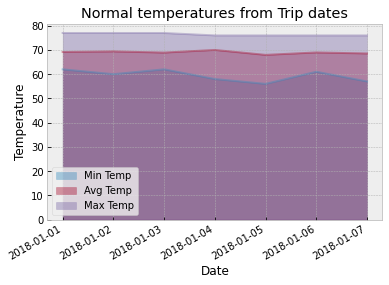

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, alpha=.4)
plt.title('Normal temperatures from Trip dates')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()